# 13. Procesamiento de Lenguaje Natural - Predicción de alza de activo

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/caracena/apunte-finanzas-computacionales/refs/heads/main/NVDA_info.csv')
df.head()

,ticker,date,description,text,title,prev_day_price,curr_day_price,next_day_price,month,year,day
0,NVDA,2023-01-03 16:12:00,New Ultimate Membership Offers Cloud Gaming at...,New Ultimate Membership Offers Cloud Gaming at...,NVIDIA Brings RTX 4080 to GeForce NOW,146.14000,143.14999,147.49001,1,2023,3
1,NVDA,2023-01-05 19:00:00,LG Electronics (LG) is demonstrating its stron...,"Company's Latest TVs Geared up With Luna, GeFo...",LG TVS UP THE ANTE BY PROVIDING EXPANDED SELEC...,147.49001,142.64999,148.59000,1,2023,5
2,NVDA,2023-01-09 17:38:00,Monthly disclosure of the total number of voti...,Monthly disclosure of the total number\nof vot...,GTT: Monthly disclosure of the total number of...,148.59000,156.28000,159.09000,1,2023,9
3,NVDA,2023-01-09 17:40:00,Element 25 Ltd (ASX:E25) managing director Jus...,"Melbourne, Victoria --News Direct-- Element 25...",Element 25 inks pivotal manganese supply deal ...,148.59000,156.28000,159.09000,1,2023,9
4,NVDA,2023-01-09 17:49:00,Trading resumes in:,"VANCOUVER, BC, Jan. 9, 2023 /CNW/ - Trading re...",IIROC Trading Resumption - TEA,148.59000,156.28000,159.09000,1,2023,9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ticker          786 non-null    object 
 1   date            786 non-null    object 
 2   description     786 non-null    object 
 3   text            786 non-null    object 
 4   title           786 non-null    object 
 5   prev_day_price  786 non-null    float64
 6   curr_day_price  786 non-null    float64
 7   next_day_price  786 non-null    float64
 8   month           786 non-null    int64  
 9   year            786 non-null    int64  
 10  day             786 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 67.7+ KB


<Axes: >

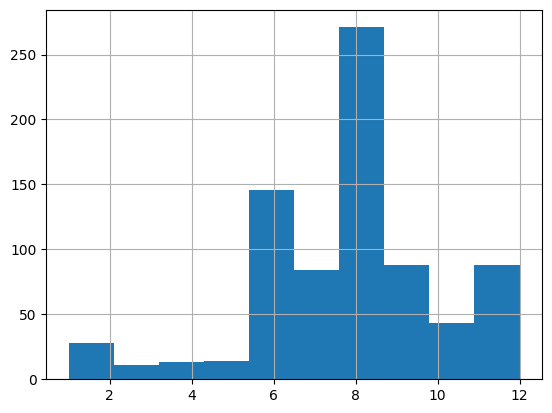

In [ ]:
df['month'].hist()

Agrupamos por fechas las noticias

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
df_grouped = df.groupby('date')

In [ ]:
df_agg = df_grouped.agg({"text": lambda x: ' '.join(x),
               "title": lambda x: ' '.join(x),
                "description": lambda x: ' '.join(x),
                "prev_day_price": "mean",
                "curr_day_price": "mean",
                "next_day_price": "mean"})

In [ ]:
df_agg['len_text'] = df_agg['text'].str.len()
df_agg['len_title'] = df_agg['title'].str.len()
df_agg['len_description'] = df_agg['description'].str.len()

Generamos una variable objetivo

In [ ]:
df_agg['price_increase_1_percent'] = (df_agg['next_day_price'] >= df_agg['curr_day_price'] * 1.01).astype(int)

In [ ]:
df_agg['price_increase_1_percent'].value_counts()

,count
price_increase_1_percent,
0,95
1,57


## TF IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_title_tfidf = tfidf_vectorizer.fit_transform(df_agg['title'])
print("Shape of TF-IDF features for 'title' column:", X_title_tfidf.shape)

Shape of TF-IDF features for 'title' column: (152, 2313)


In [ ]:
X_title_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7149 stored elements and shape (152, 2313)>

In [ ]:
X = X_title_tfidf
y = df_agg['price_increase_1_percent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (121, 2313)
Shape of X_test: (31, 2313)
Shape of y_train: (121,)
Shape of y_test: (31,)


In [ ]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.metrics import classification_report
y_pred = svm_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76        19
           1       0.00      0.00      0.00        12

    accuracy                           0.61        31
   macro avg       0.31      0.50      0.38        31
weighted avg       0.38      0.61      0.47        31



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Modelos de lenguaje pre-entrenados

In [ ]:
! pip install transformers datasets evaluate accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-cased')
model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-cased', num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import Dataset

df_hf = df_agg[['price_increase_1_percent', 'title']].rename(columns={'title': 'text', 'price_increase_1_percent':'label'})
hf_dataset = Dataset.from_pandas(df_hf)
#

In [ ]:
hf_dataset = hf_dataset.remove_columns('date')

In [ ]:
split_dataset = hf_dataset.train_test_split(test_size=0.2)

In [ ]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 121
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 31
    })
})

In [ ]:
def tokenize_dataset(dataset):
    return tokenizer(dataset["text"], padding="max_length", truncation=True)
dataset = split_dataset.map(tokenize_dataset, batched=True)

Map:   0%|          | 0/121 [00:00<?, ? examples/s]

Map:   0%|          | 0/31 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 121
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31
    })
})

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
  acc = accuracy_score(labels, predictions)
  return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="BERT-nvda",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    push_to_hub=False,
    report_to="none",
    save_strategy="epoch",
    logging_strategy="epoch",

)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.758500,0.627063,0.645161,0.556610,0.489433,0.645161
2,0.669100,0.626658,0.709677,0.589166,0.503642,0.709677
3,0.642500,0.643514,0.645161,0.556610,0.489433,0.645161


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
trainer.evaluate()

{'eval_loss': 0.6435137987136841,
 'eval_accuracy': 0.6451612903225806,
 'eval_f1': 0.5566097406704617,
 'eval_precision': 0.489432703003337,
 'eval_recall': 0.6451612903225806,
 'eval_runtime': 1.0912,
 'eval_samples_per_second': 28.41,
 'eval_steps_per_second': 1.833,
 'epoch': 3.0}